<a href="https://colab.research.google.com/github/ChickenRob0t/Proyecto-Covid-Meteorologia/blob/main/S_S_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### En este código se acomoda la base de datos de los contagios del COVID para entregar las variables de interés y con el formato conveniente.
Aquí asigna a cada caso una (o varias) estaciones metereológicas en función de la distancia.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Carga de datos
Covi=pd.read_excel("/content/drive/MyDrive/Datos S.S/Data/Base_datos_COVID2020_2022 (1).xlsx")

/usr/local/lib/python3.10/dist-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [ ]:
col_i=['FECINGRE','LOCRESI','LATLOCA','LONGLOCA','CP','RESDEFIN']   #Filtramos a las columnas importantes
Import=Covi.loc[:,col_i]


In [ ]:
confirmados=Import.loc[Import['RESDEFIN'].str.contains('SARS') | Import['RESDEFIN'].str.contains('CORONA') ] #Sólo los que tienen covid

#Guardo las primeras 40 localidades que tengan más personas
Localidades=confirmados['LOCRESI'].value_counts()[0:40].index.tolist()


*Aquí me concentré en intentar que todos los datos tuvieran un CP*

In [ ]:
#Con este ciclo for si es NaN, '-' o '0.0' el CP,  intenta cambiarlos por el valor que más se repita de su localidad
for i in Localidades:


  max=confirmados.loc[confirmados['LOCRESI']== i]['CP'].value_counts().idxmax()

  if max in(['-',0.0]):
    confirmados['CP'].loc[(confirmados['LOCRESI']== i) & confirmados['CP'].isin ([np.nan,'-']) ]='pass'
    continue

  confirmados['CP'].loc[(confirmados['LOCRESI']== i) & confirmados['CP'].isin ([np.nan,'-',0.0]) ]=max

  #Con esto pasamos de tener 922 valores sin conocer a únicamente tener 382


<ipython-input-6-287dd4b2b851>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  confirmados['CP'].loc[(confirmados['LOCRESI']== i) & confirmados['CP'].isin ([np.nan,'-',0.0]) ]=max
<ipython-input-6-287dd4b2b851>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  confirmados['CP'].loc[(confirmados['LOCRESI']== i) & confirmados['CP'].isin ([np.nan,'-']) ]='pass'
<ipython-input-6-287dd4b2b851>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

In [ ]:
#Marcamos esos 382 que no sabemos bien, quizás con otro parámetro se sabe en qué estación están
confirmados['CP'].iloc[confirmados['CP'].isin(['pass',0.0,'SD','-','.',np.nan])]=0
#Ahora ya tenemos todos los valores del CP, podemos pasar a encontrar sus valores de la latitud y longitud
confirmados.loc[confirmados['CP']=='4433O']=4430 #Problemilla de más delante

<ipython-input-7-8250884834b4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  confirmados['CP'].iloc[confirmados['CP'].isin(['pass',0.0,'SD','-','.',np.nan])]=0


In [ ]:

#Aquí es para acomodar un poco la base de datos para lo que viene

confirmados['CP']=confirmados['CP'].apply(lambda x: int(float(x))) #Quitamos los decimales en el CP
confirmados['FECINGRE']=confirmados['FECINGRE'].apply( lambda x: pd.to_datetime(x).strftime('%Y-%m-%d' ) ) #Quitamos las horas de la fecha de ingreso y egreso

confirmados.sort_values(by='FECINGRE',inplace=True)  #Reiniciamos el índice y acomodamos por fechas
confirmados=confirmados.reset_index(drop=True)


<ipython-input-8-8dfa18cfe235>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  confirmados['CP']=confirmados['CP'].apply(lambda x: int(float(x))) #Quitamos los decimales en el CP
<ipython-input-8-8dfa18cfe235>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  confirmados['FECINGRE']=confirmados['FECINGRE'].apply( lambda x: pd.to_datetime(x).strftime('%Y-%m-%d' ) ) #Quitamos las horas de la fecha de ingreso y egreso
<ipython-input-8-8dfa18cfe235>:6: SettingWithCopyWarning: 
A value is trying to be set on a c

## *Enlazamos los casos con las estaciones más cercanas*

In [ ]:
confirmados_2=confirmados  #Hacemos una copia para ver si funciona, si funciona lo aplicamos a todo jeje

In [ ]:
confirmados_2['ESTACIONES']=np.zeros(len(confirmados_2))

#Los nombres que directamente son los de las estaciones se los asignamos
confirmados_2['ESTACIONES'].loc[confirmados_2['LOCRESI']=='ZAPOPAN']='Zapopan'
#confirmados_2['ESTACIONES'].loc[confirmados_2['LOCRESI']=='ZAPOTLANEJO']='Zapotlanejo'
#confirmados_2['ESTACIONES'].loc[confirmados_2['LOCRESI']=='TLAJOMULCO DE ZU?IGA']='Prepa 20'

confirmados_2['ESTACIONES'].loc[confirmados_2['LOCRESI']=='TONALA']='Tonala'
confirmados_2['ESTACIONES'].loc[confirmados_2['LOCRESI']=='TLAQUEPAQUE']='Tlaquepaque'

n=(confirmados_2['ESTACIONES']==0.0).sum()
print('Todavía hay '+ str(n) + ' casos que no se sabe a qué estación pertenecen')


Todavía hay 2066 casos que no se sabe a qué estación pertenecen


<ipython-input-10-fd8138eda00a>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  confirmados_2['ESTACIONES'].loc[confirmados_2['LOCRESI']=='ZAPOPAN']='Zapopan'


In [ ]:
CPS=pd.read_csv('/content/drive/MyDrive/Datos S.S/Data/PP.csv')
CPS=CPS.rename(columns={CPS.columns[0]:'CP', CPS.columns[1]:'Estacion'})


In [ ]:
for i in range(len(CPS)):
  confirmados_2['ESTACIONES'].loc[ confirmados_2['CP']==CPS['CP'][i] ]=CPS['Estacion'][i]


In [ ]:
Casos_N=(confirmados_2['ESTACIONES']==0).sum() #Ahora sólo quedan 866 personas positivas que no sabemos a qué estación pertenecen
print('Terminamos con '+ str(len(confirmados_2)-Casos_N) + ' personas que se sabe a que estación pertenece y ' + str(Casos_N) + ' que no se sabe')

Terminamos con 2633 personas que se sabe a que estación pertenece y 1529 que no se sabe


In [ ]:
ultim=confirmados_2.loc[confirmados_2['ESTACIONES']!=0.0] #dejamos únicamente los valores que sí tienen una estación
ultim=ultim.reset_index(drop=True)
ultim['ESTACIONES'].loc[ultim['ESTACIONES']=='tonala']='Tonala'

<ipython-input-14-c6da73840bd0>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ultim['ESTACIONES'].loc[ultim['ESTACIONES']=='tonala']='Tonala'


In [ ]:
ultim['ESTACIONES'].unique()

array(['Zapopan', 'Prepa 20', 'Experiencia', 'UAG', 'Tlaquepaque', 'IAM',
       'Tonala', 'Guadalajara', 'Molinos'], dtype=object)

In [ ]:
#Lo último que haremos aquí es entregarle una latitud y longitud a cada uno dependiendo de la estación, esto para que al generar el mapa sea sencillo ubicarlos
Points={'IAM' :(20.674609, -103.384118),'Guadalajara':(20.66682,-103.39182), 'Prepa 20': (20.63019, -103.46544), 'UAG': (20.68703, -103.39194), 'Tlaquepaque':(20.64091,-103.29327), 'Zapopan':(20.7252, -103.38905), 'Tonala':(20.62449, -103.24089),'Molinos': (20.80566, -103.45767),'Experiencia':(20.67011, -103.2855)}

In [ ]:
for i in Points:
  ultim['LATLOCA'].loc[ultim['ESTACIONES']==i] = Points[i][0]
  ultim['LONGLOCA'].loc[ultim['ESTACIONES']==i] = Points[i][1]

<ipython-input-17-05d95c056202>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ultim['LATLOCA'].loc[ultim['ESTACIONES']==i] = Points[i][0]
<ipython-input-17-05d95c056202>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ultim['LONGLOCA'].loc[ultim['ESTACIONES']==i] = Points[i][1]


In [ ]:
ultim.set_index('FECINGRE')  #Ahora podríamos hacer un dataset o una lista en la cual para cada estación en cada uno de los días nos dijera cuántos con covid hubieron para
                             #así poder plotearlo

                             #Recordatorio para aquí quitar Zapotlanejo y plaza del Sol
ultim

,FECINGRE,LOCRESI,LATLOCA,LONGLOCA,CP,RESDEFIN,ESTACIONES
0,2020-01-20,ZAPOPAN,20.72520,-103.38905,45180,CORONA HKU1,Zapopan
1,2020-01-23,ZAPOPAN,20.72520,-103.38905,45130,CORONA HKU1,Zapopan
2,2020-01-23,ZAPOPAN,20.72520,-103.38905,45130,CORONA HKU1,Zapopan
3,2020-01-30,ZAPOPAN,20.72520,-103.38905,45180,CORONA NL63,Zapopan
4,2020-02-13,ZAPOPAN,20.63019,-103.46544,45069,CORONA HKU1,Prepa 20
...,...,...,...,...,...,...,...
2628,2022-02-15,ZAPOPAN,20.72520,-103.38905,45180,SARS-CoV-2,Zapopan
2629,2022-02-15,TLAQUEPAQUE,20.62449,-103.24089,45625,SARS-CoV-2,Tonala
2630,2022-02-18,ZAPOPAN,20.72520,-103.38905,45040,SARS-CoV-2,Zapopan
2631,2022-02-25,ZAPOPAN,20.80566,-103.45767,45134,SARS-CoV-2,Molinos


#Aquí adapto la base de datos para que nos dé cuantos contagios hubo en cada día 2021-2022

In [ ]:

Fechas=ultim['FECINGRE'].unique()
Estaciones=ultim['ESTACIONES'].unique()
Date_cero=pd.DataFrame()   #Este nos ayudará a poner los días que no hubo contagios

In [ ]:
from datetime import date, timedelta

#Generamos una lista con todos los días de 2020-2022

# fecha inicial y final
start_date = date(2020, 1, 1)
end_date = date(2021, 12, 31)

# lista para almacenar las fechas
dates = []

# bucle para agregar un día a la fecha inicial hasta llegar a la fecha final
while start_date <= end_date:
    dates.append(start_date)
    start_date += timedelta(days=1)

In [ ]:
Date_cero['FECINGRE']=dates                                         #Dataframe auxiliar
Dates=ultim.groupby(['FECINGRE'])['FECINGRE'].size().reset_index(name='COUNT')  #Dataframe con los valores de contagio para los días que tiene una base de datos

Dates['FECINGRE']=pd.to_datetime(Dates['FECINGRE'])                             #Ambos los hacemos tipo datetime para que sean compatibles
Date_cero['FECINGRE']=pd.to_datetime(Date_cero['FECINGRE'])

In [ ]:
Count_days=(pd.merge(Date_cero,Dates,how='left',on='FECINGRE')).fillna(0)

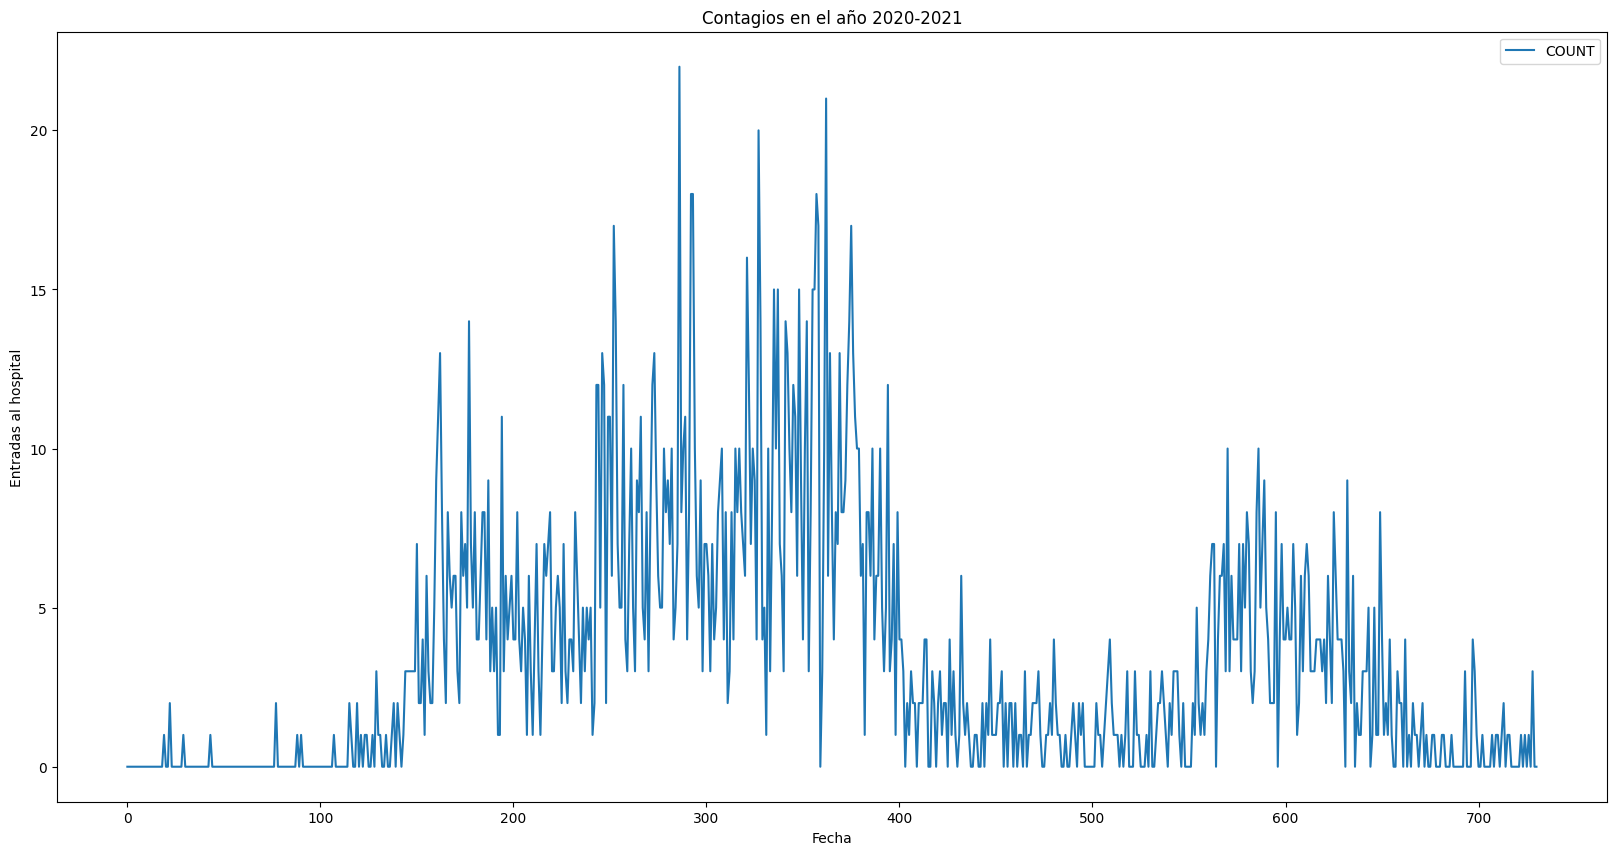

In [ ]:
Count_days.plot.line(y='COUNT',figsize=(20,10))
plt.ylabel('Entradas al hospital')
plt.xlabel('Fecha')
plt.title('Contagios en el año 2020-2021')
plt.savefig('Entradas.png',dpi=200)

#Count_days, con estaciones de

In [ ]:
#Podría hacer una para cada estación, con esto ya sólo sería comparar con las demás bases de datos y ya terminé xd
Esta_str=['UAG','Experiencia','Prepa 20','Molinos','IAM','Guadalajara','Tlaquepaque','Zapopan','Tonala'] #Todas las estaciones, para que queden igual acomodadas como en el otro notebook

#Acabo de ver que no conté Acatlán en esta base de datos, tendría que cambiar algunas posiciones para ver en qué lugar quedan mejor :(, chales eso será para después, por ahora me concentraré en lo que tengo

Estaciones_count=[]

In [ ]:
#Aquí hago un dataframe contando los casos por día en cada estación hay 9 estaciones, cada elemento de la lista es un dataframe
#Sólo hace falta cambiar las cosillas que tengo que cambiar y ya tendría el programa que nos dejará ver si hay coincidencias
for i in Esta_str:
  loqueado=ultim.loc[ultim['ESTACIONES']==i]

  Dates_2=loqueado.groupby(['FECINGRE'])['FECINGRE'].size().reset_index(name='COUNT')

  Dates_2['FECINGRE']=pd.to_datetime(Dates_2['FECINGRE'])                             #Ambos los hacemos tipo datetime para que sean compatibles

  Date_cero['FECINGRE']=pd.to_datetime(Date_cero['FECINGRE'])

  Estaciones_count.append(pd.merge(Date_cero,Dates_2,how='left',on='FECINGRE').fillna(0) )

In [ ]:
Estaciones_D= dict(zip(Esta_str,range(len(Estaciones)) ))
Estaciones_D

{'UAG': 0,
 'Experiencia': 1,
 'Prepa 20': 2,
 'Molinos': 3,
 'IAM': 4,
 'Guadalajara': 5,
 'Tlaquepaque': 6,
 'Zapopan': 7,
 'Tonala': 8}

Text(0.5, 0, 'Fecha')

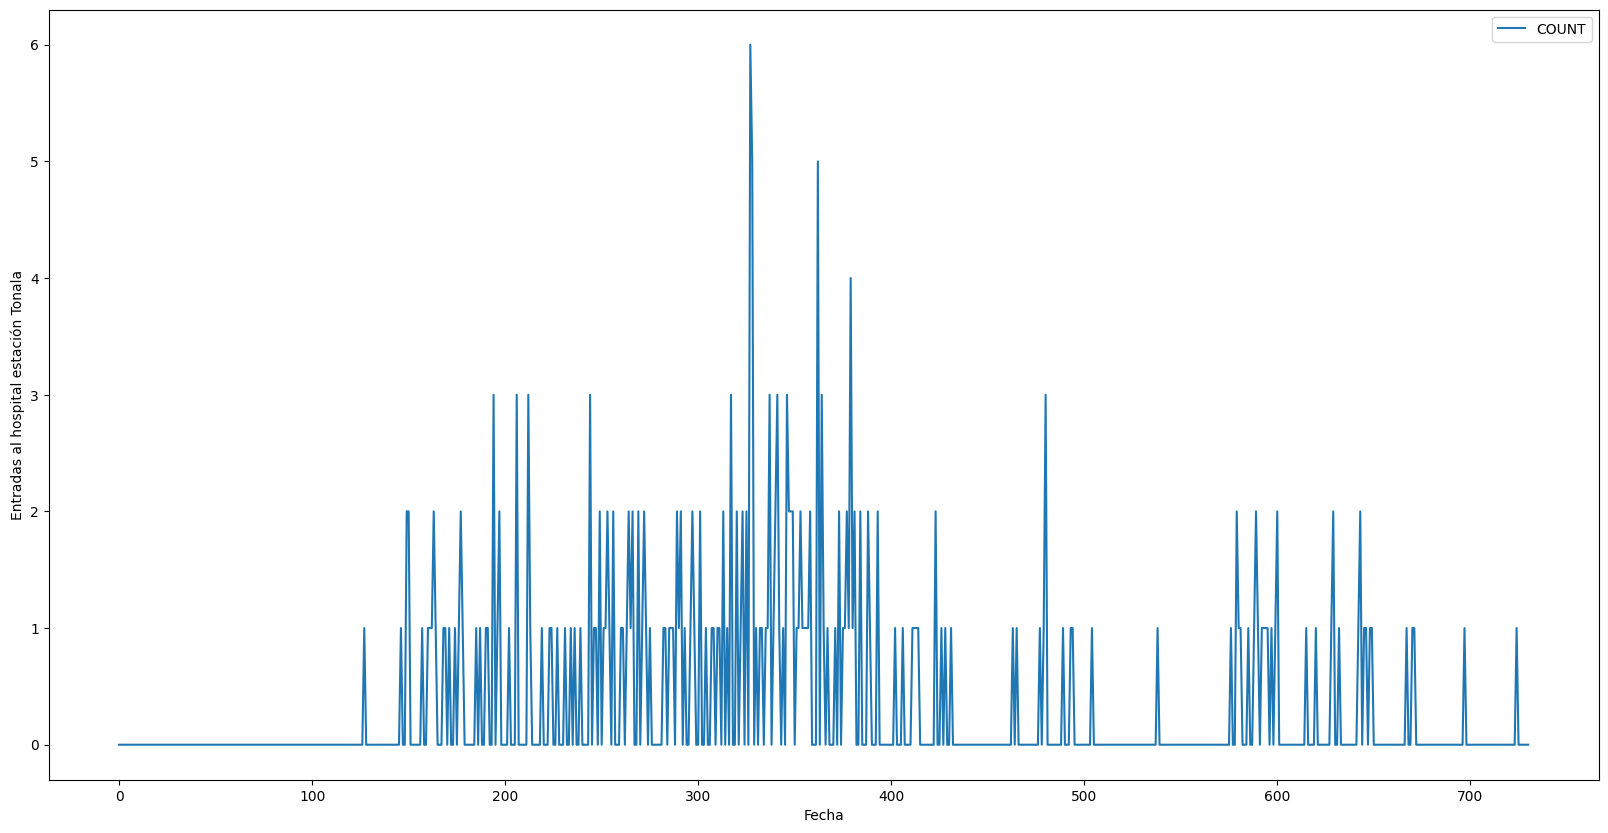

In [ ]:
s=8
Estaciones_count[s].plot.line(y='COUNT',figsize=(20,10))
plt.ylabel('Entradas al hospital estación '+ str(Esta_str[s]))
plt.xlabel('Fecha')

In [ ]:
#Ya arreglado lo de no poner más personas en una estación de lo que deberían, quitar las malas estaciones, ahora sólo nos falta plotear las personas junto con los valores del clima para ver si hay correlación
#Y ahora sí, viene la parte del ML jsjsjs uwu
#También podría meter la parte del geopandas para que se vea más pro